# MLflow for Darts

This notebook demonstrates how to use Darts with MLflow for experiment tracking, model versioning, and management.
If you are new to Darts, please check out the [Quickstart Guide](https://unit8co.github.io/darts/quickstart/00-quickstart.html) before proceeding.

MLflow is an open-source platform for managing the end-to-end machine learning lifecycle. It provides tools for tracking experiments, packaging code into reproducible runs, sharing and deploying models, and managing model versions in a central registry. With Darts' MLflow integration, you can easily log forecasting models, compare experiments, and manage model versions throughout your forecasting workflow.

For more details, see the [MLflow documentation](https://mlflow.org/docs/latest/index.html).

## Installing MLflow

MLflow is available as an optional dependency for Darts. Install it with:

```bash
pip install mlflow
```

## Setup and Imports

In [25]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
%matplotlib inline

import os
import tempfile

import matplotlib.pyplot as plt
import mlflow
import numpy as np

from darts.datasets import AirPassengersDataset
from darts.metrics import mape, rmse
from darts.models import ExponentialSmoothing, LinearRegressionModel, NBEATSModel
from darts.utils.mlflow import autolog, load_model, log_model, save_model

In [27]:
# use darts plotting style
from darts import set_option

set_option("plotting.use_darts_style", True)

## MLflow Setup

First, let's configure MLflow tracking. We'll use a temporary directory for this example, however you can choose from any of the supported MLflow [tracking backends](https://mlflow.org/docs/latest/self-hosting/architecture/tracking-server/#backend-store) such as local filesystem, SQLite, PostgreSQL, MySQL, or cloud storage solutions like S3 or Azure Blob Storage.

In [ ]:
# temporary directory for MLflow tracking
tmpdir = tempfile.mkdtemp()
mlflow_db = os.path.join(tmpdir, "mlflow.db")

mlflow.set_tracking_uri(f"sqlite:///{mlflow_db}")
mlflow.set_experiment("darts-quickstart")

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {mlflow.get_experiment_by_name('darts-quickstart').name}")

## Load Sample Data

We'll use the classic AirPassengers dataset for this example.

Training series: 107 points
Validation series: 37 points


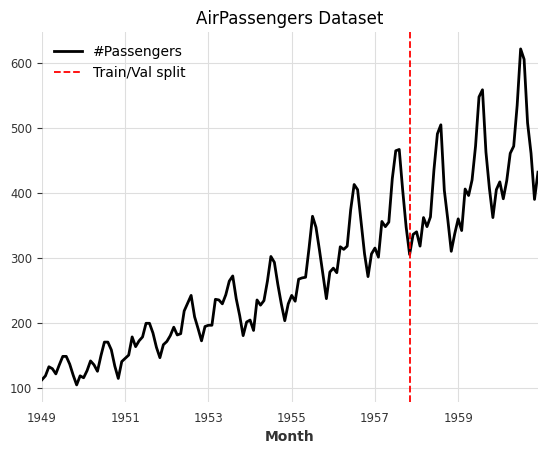

In [29]:
series = AirPassengersDataset().load()
train, val = series.split_before(0.75)

print(f"Training series: {len(train)} points")
print(f"Validation series: {len(val)} points")

series.plot()
plt.axvline(train.end_time(), color="red", linestyle="--", label="Train/Val split")
plt.legend()
plt.title("AirPassengers Dataset")
plt.show()

## Basic Model Logging

Let's train a simple model and log it to MLflow manually.

Validation MAPE: 7.86%
Validation RMSE: 34.77


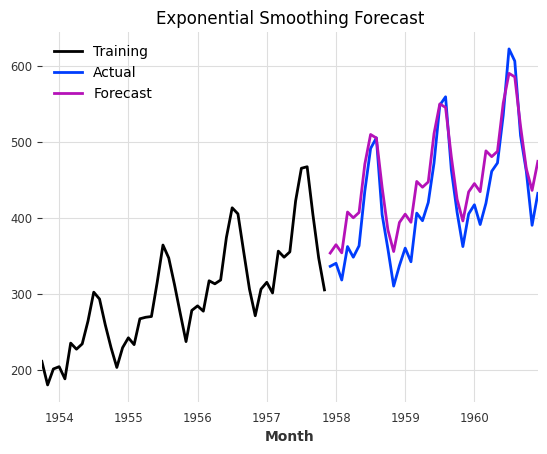

In [30]:
model = ExponentialSmoothing()
model.fit(train)

predictions = model.predict(n=len(val))

# calculate metrics you want to log to MLflow
mape_score = mape(val, predictions)
rmse_score = rmse(val, predictions)

print(f"Validation MAPE: {mape_score:.2f}%")
print(f"Validation RMSE: {rmse_score:.2f}")

train[-50:].plot(label="Training")
val.plot(label="Actual")
predictions.plot(label="Forecast")
plt.legend()
plt.title("Exponential Smoothing Forecast")
plt.show()

Now let's log this model to MLflow:

In [31]:
with mlflow.start_run(run_name="exponential-smoothing-baseline") as run:
    model_info = log_model(
        model=model,
        name="model",
        log_params=True,  # True by default, logs all model params
    )

    # log calculated metrics you want
    mlflow.log_metric("val_mape", mape_score)
    mlflow.log_metric("val_rmse", rmse_score)

    # log any additional tags you want
    mlflow.set_tag("model_type", "ExponentialSmoothing")
    mlflow.set_tag("dataset", "AirPassengers")

    print(f"Run ID: {run.info.run_id}")
    print(f"Model URI: {model_info.model_uri}")

Run ID: 936e44cf2edb4db0bc6e32aa0d9fdfd9
Model URI: models:/m-280d9919c51642dabaf49017ad97ca65


### Load the Model Back

We can load the model from MLflow using its URI:

In [32]:
loaded_model = load_model(model_info.model_uri)

loaded_predictions = loaded_model.predict(n=len(val))

# verify predictions match
predictions_match = np.allclose(predictions.values(), loaded_predictions.values())
print(f"Loaded model predictions match: {predictions_match}")

Loaded model predictions match: True


## Automatic Logging with `autolog()`

`autolog()` patches every `model.fit()` call to automatically log parameters, covariate metadata, and the trained model artifact. For PyTorch-based models it also injects a callback that logs `train_loss` / `val_loss` per epoch (see the sections below for details).

Logged metrics: {'train_mae': 8.4783, 'train_mape': 3.9116, 'train_mse': 118.1369, 'train_rmse': 10.8691, 'val_mape': 10.742, 'val_rmse': 51.182}


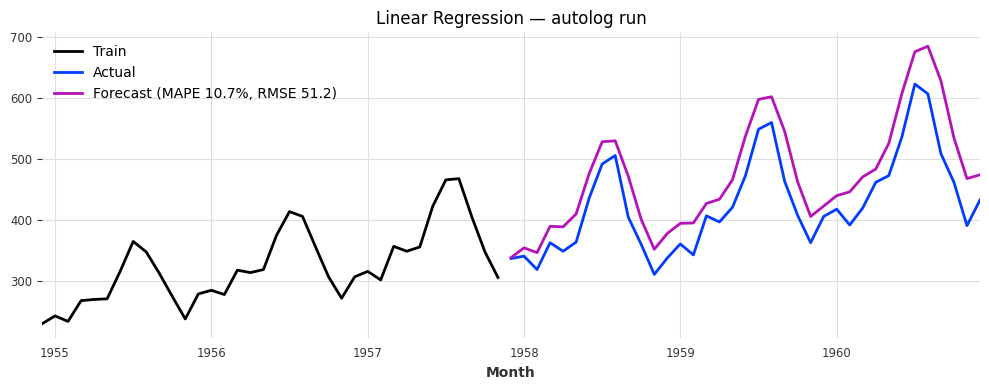

In [33]:
autolog()

with mlflow.start_run(run_name="linear-regression-autolog") as run:
    auto_model = LinearRegressionModel(lags=12)
    auto_model.fit(train)  # no val_series → autolog logs train_* metrics by default

    auto_predictions = auto_model.predict(n=len(val))
    auto_mape = mape(val, auto_predictions)
    auto_rmse = rmse(val, auto_predictions)
    mlflow.log_metric("val_mape", auto_mape)
    mlflow.log_metric("val_rmse", auto_rmse)

autolog(disable=True)

# show logged metrics
logged = mlflow.tracking.MlflowClient().get_run(run.info.run_id).data.metrics
print("Logged metrics:", {k: round(v, 4) for k, v in sorted(logged.items())})

# plot
fig, ax = plt.subplots(figsize=(10, 4))
train[-36:].plot(label="Train", ax=ax)
val.plot(label="Actual", ax=ax)
auto_predictions.plot(
    label=f"Forecast (MAPE {auto_mape:.1f}%, RMSE {auto_rmse:.1f})", ax=ax
)
ax.set_title("Linear Regression — autolog run")
ax.legend()
plt.tight_layout()
plt.show()

## Open the MLflow UI

To experiment with the runs yourself, open the **MLflow UI** to explore them interactively. Run the command printed below in a separate terminal, then navigate to `http://localhost:5000`.

The UI lets you:
- **Compare runs** side-by-side in the Experiments table
- **Inspect** individual run parameters, metrics, and logged artifacts
- **Visualize** metrics across runs with built-in charts
- **Register** models to the Model Registry for versioning

In [34]:
print("Launch the MLflow UI with this command in your terminal:\n")
print(f"  mlflow ui --backend-store-uri {mlflow.get_tracking_uri()}\n")
print("Then open:  http://localhost:5000")

Launch the MLflow UI with this command in your terminal:

  mlflow ui --backend-store-uri sqlite:////var/folders/yr/3703qwtj56lcw6n91xm6tq_r0000gn/T/tmph5ei82gg/mlflow.db

Then open:  http://localhost:5000


> 📸 **Try it:** Open the UI, switch to the `darts-quickstart` experiment, and sort the **Table view** by `val_mape` to instantly see which model performs best. Click any run name to see its parameters, tags, and logged artifacts.
>
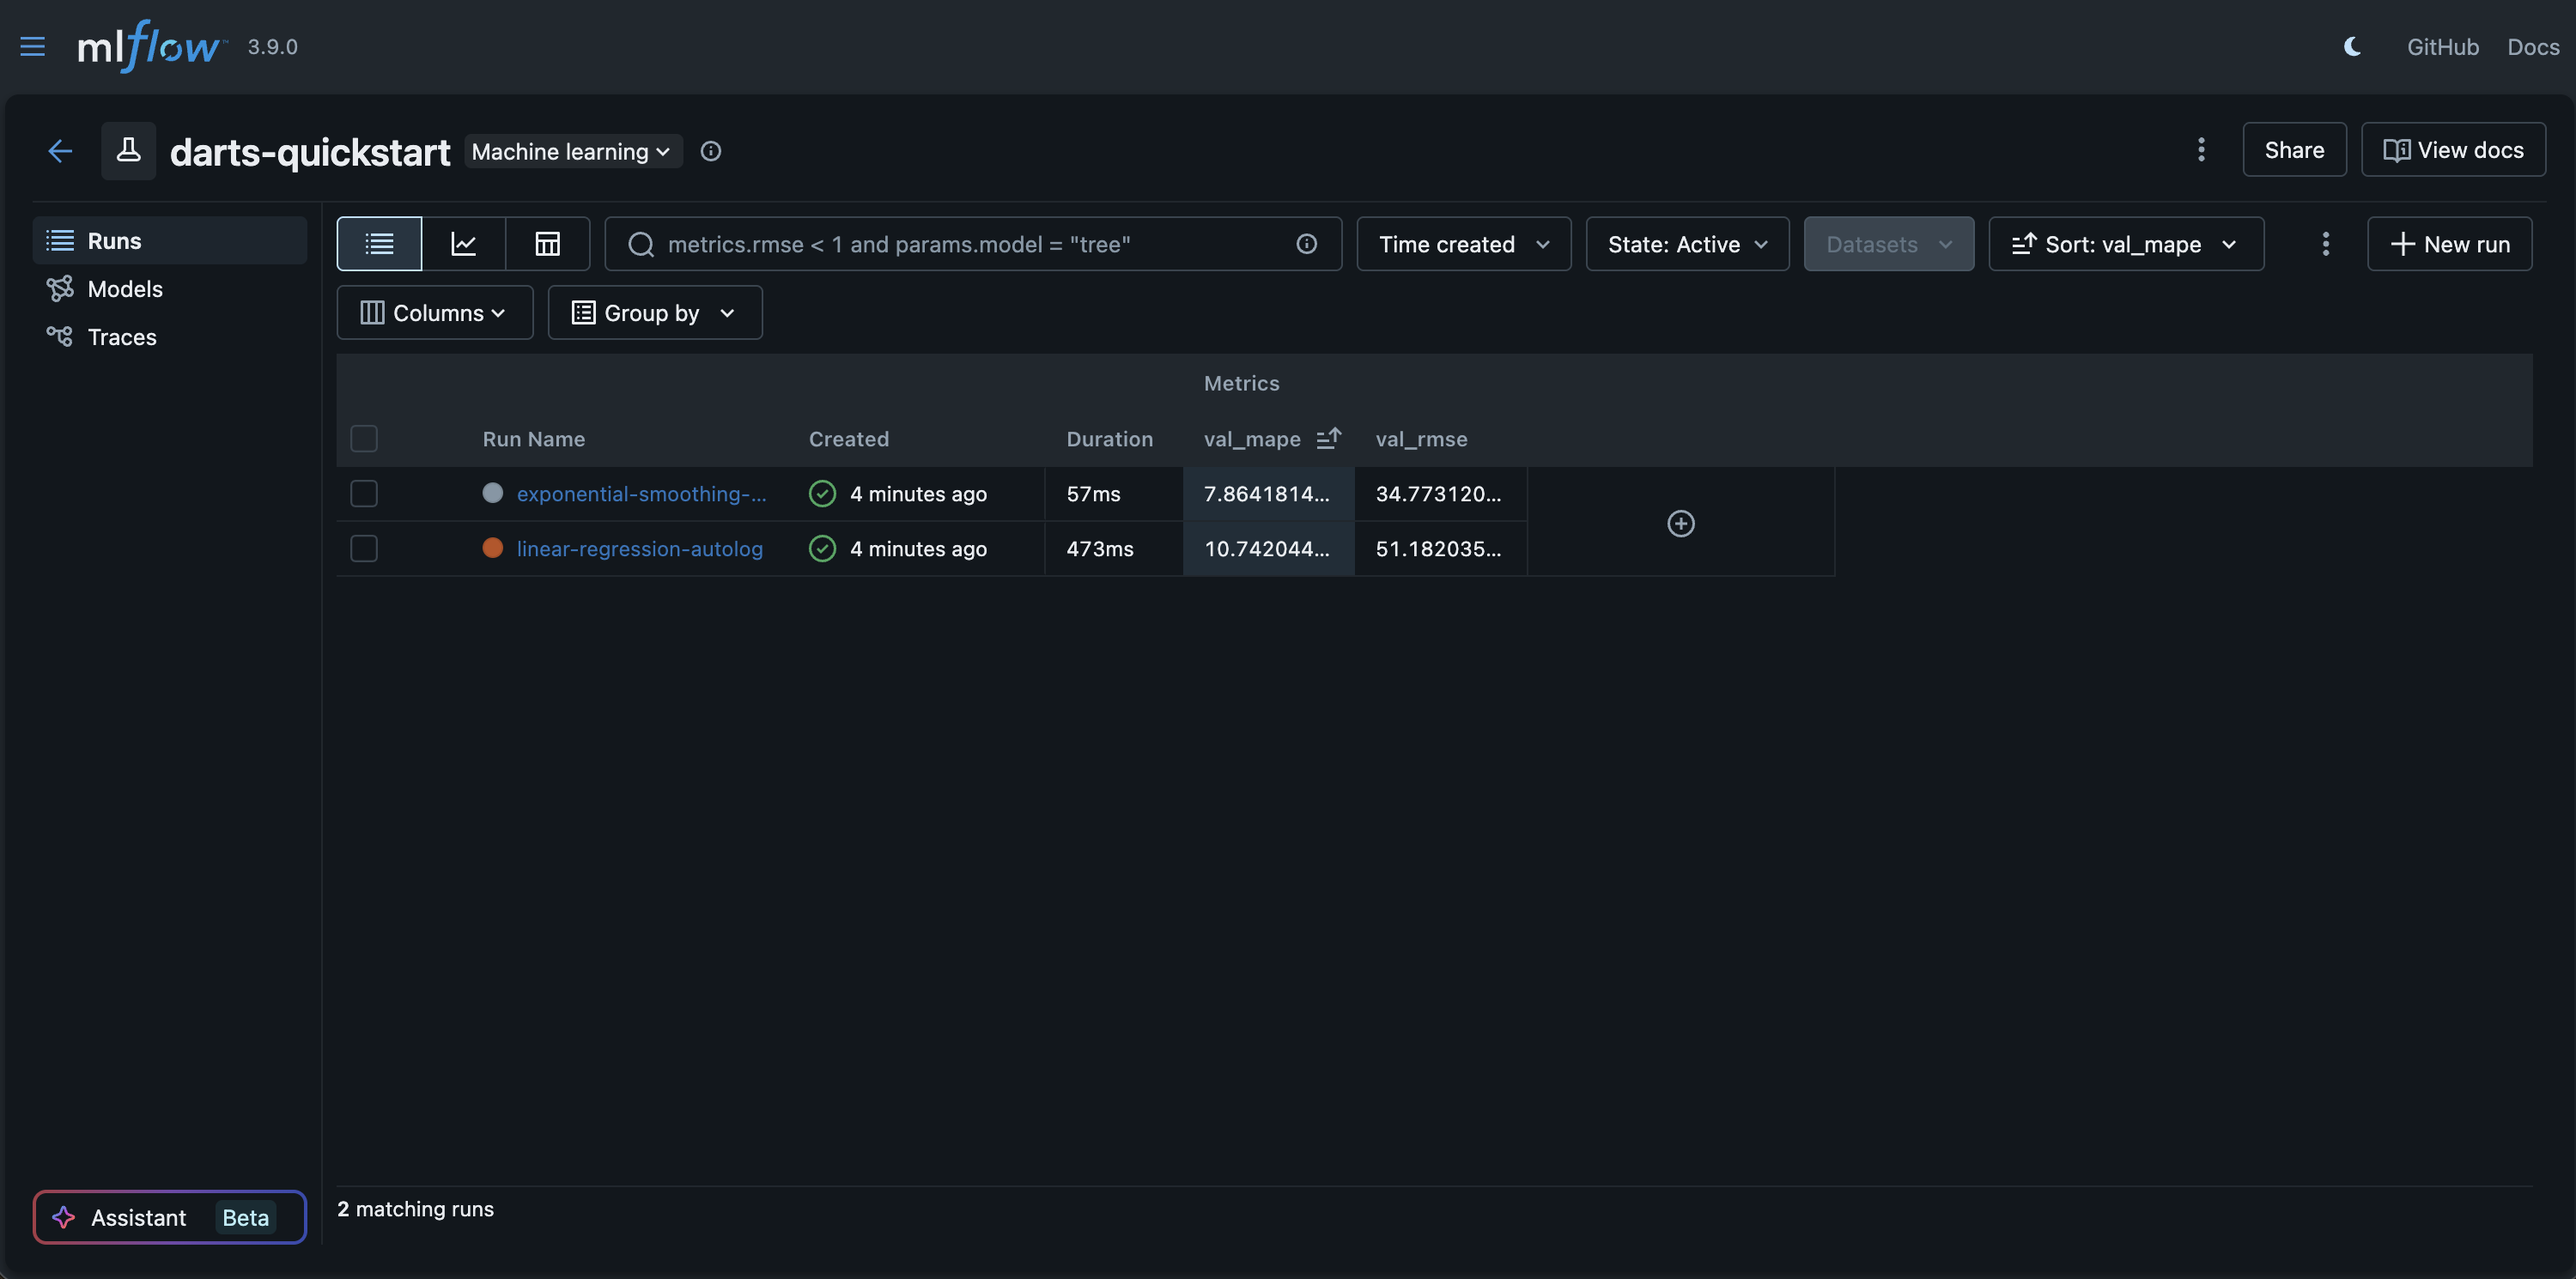

## Per-epoch Metrics with Torch Models

For neural models, `autolog()` by default injects a PyTorch Lightning callback that logs `train_loss` and `val_loss` at the end of every epoch.

Pass `torch_metrics` to the model to add extra per-epoch metrics (e.g. MAE, MSE). They will appear prefixed as `train_MAE`, `val_MAE`, etc.

In [ ]:
from torchmetrics import MeanAbsoluteError, MeanSquaredError, MetricCollection

# inject_per_epoch_callbacks=True is the default
autolog()

with mlflow.start_run(run_name="nbeats-epoch-metrics"):
    nbeats = NBEATSModel(
        input_chunk_length=24,
        output_chunk_length=12,
        n_epochs=10,
        pl_trainer_kwargs={"accelerator": "cpu"},
        # these are logged per epoch as train_MAE, val_MAE, train_MSE, val_MSE
        torch_metrics=MetricCollection({
            "MAE": MeanAbsoluteError(),
            "MSE": MeanSquaredError(),
        }),
        random_state=42,
    )
    nbeats.fit(train, val_series=val)
    nbeats_pred = nbeats.predict(n=len(val))
    mlflow.log_metric("val_mape", mape(val, nbeats_pred))
    mlflow.log_metric("val_rmse", rmse(val, nbeats_pred))
    print(f"NBEATS MAPE: {mape(val, nbeats_pred):.2f}%")

autolog(disable=True)

> 📸 **Try it:** Click on the `nbeats-epoch-metrics` run in the UI, then open the **Model metrics** tab. You'll see `train_loss`, `val_loss`, `train_MAE`, and `val_MAE` plotted as learning curves across epochs.
>
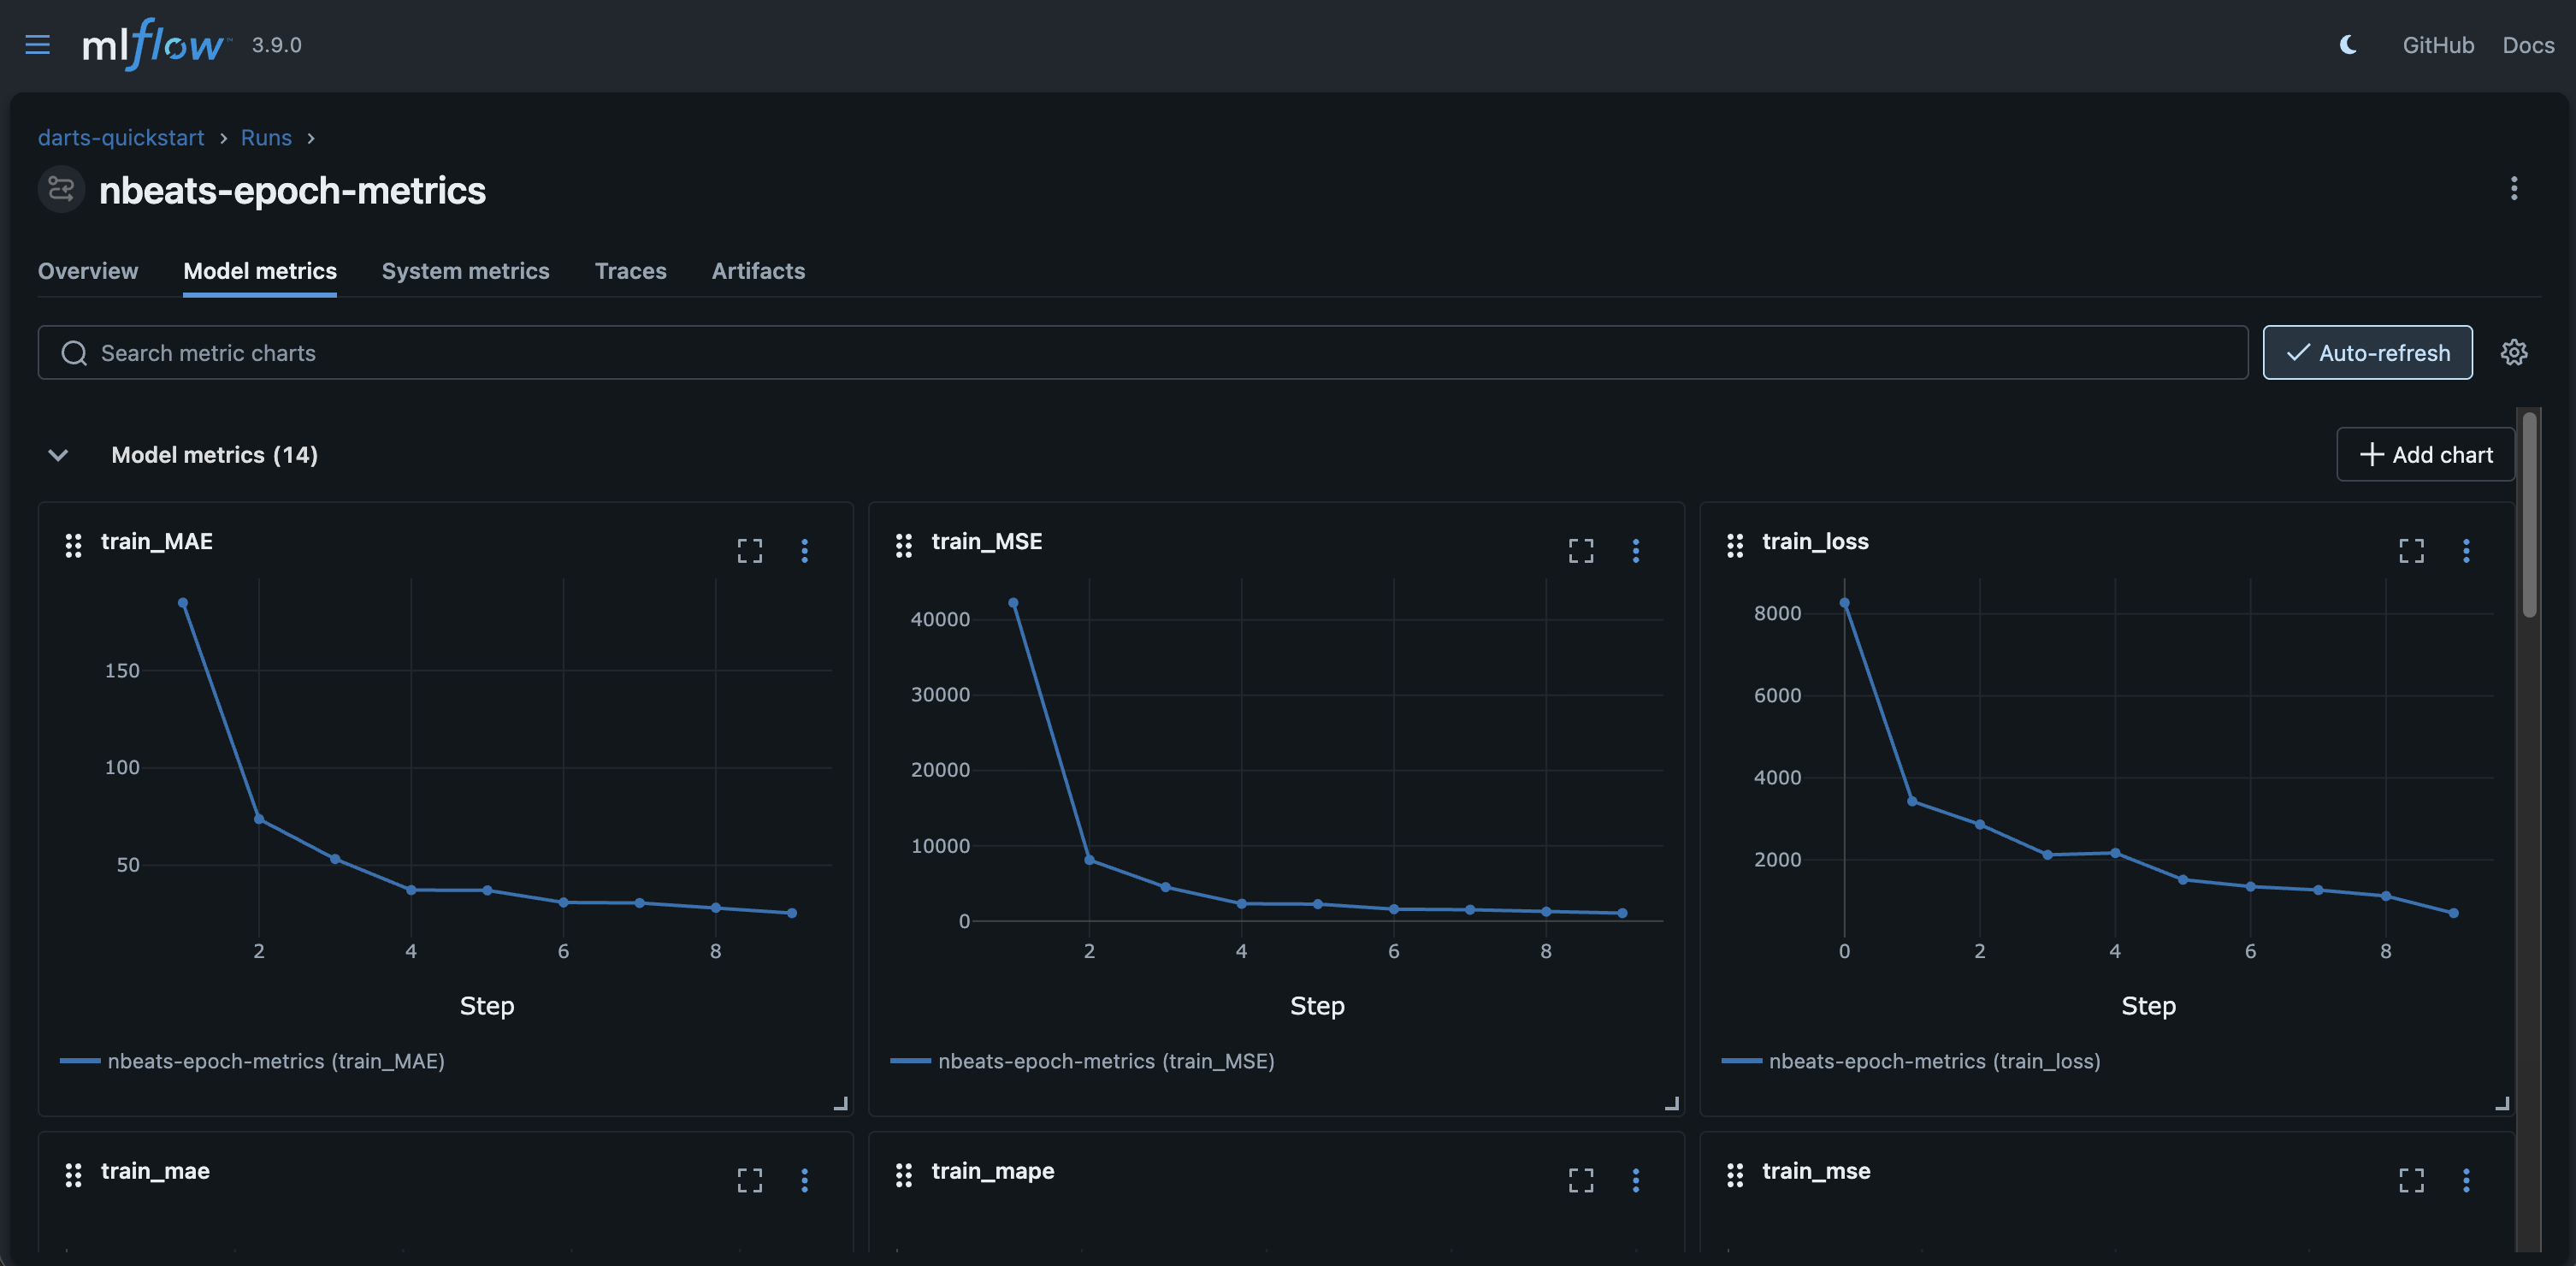

## Training & Validation Forecast Metrics

Beyond per-epoch loss, `autolog()` can also run a backtest after training and log evaluation metrics (MAE, RMSE, MAPE, …) on both the **training series** and the **validation series**. Enable this with `log_training_metrics=True` and `log_validation_metrics=True`. Pass `extra_metrics` to extend the default set.

In [36]:
from darts.metrics import mae, smape

autolog(
    log_training_metrics=True,
    log_validation_metrics=True,
    extra_metrics=[smape, mae],  # add smape and mae on top of the defaults
)

with mlflow.start_run(run_name="linear-regression-full-metrics") as run:
    lr_model = LinearRegressionModel(lags=12)
    # if val_series is provided, autolog will log val_* metrics based on it
    lr_model.fit(train, val_series=val)
    # autolog already computed and logged train_mae, val_rmse, val_smape, ...
    # manually log the final hold-out MAPE as well
    lr_pred = lr_model.predict(n=len(val))
    mlflow.log_metric("manual_mape", mape(val, lr_pred))
    run_id = run.info.run_id

autolog(disable=True)

# show what was logged
client = mlflow.tracking.MlflowClient()
run_metrics = client.get_run(run_id).data.metrics
metric_names = sorted(run_metrics.keys())
print(f"All logged metrics ({len(metric_names)}):")
for name in metric_names:
    print(f"  {name}: {run_metrics[name]:.4f}")

All logged metrics (11):
  manual_mape: 10.7420
  train_mae: 8.4783
  train_mape: 3.9116
  train_mse: 118.1369
  train_rmse: 10.8691
  train_smape: 3.8915
  val_mae: 12.5800
  val_mape: 2.9449
  val_mse: 243.0054
  val_rmse: 15.5886
  val_smape: 2.9130


## Saving and Loading Models Locally

You can also save and load models to/from local paths without MLflow runs.

In [37]:
# Save model to local directory
local_model_path = os.path.join(tmpdir, "my_model")
save_model(model, path=local_model_path)

print("\nFiles in model directory:")
for file in os.listdir(local_model_path):
    print(f"  - {file}")


Files in model directory:
  - python_env.yaml
  - requirements.txt
  - MLmodel
  - conda.yaml
  - data


In [38]:
# Load model from local directory
local_loaded_model = load_model(f"file://{local_model_path}")

# Test it
local_predictions = local_loaded_model.predict(n=5)
print("Loaded model successfully!")
print(f"Predictions shape: {local_predictions.values().shape}")

Loaded model successfully!
Predictions shape: (5, 1)


## Querying Experiments

You can programmatically query and compare runs.

In [39]:
from mlflow.tracking import MlflowClient

experiment = mlflow.get_experiment_by_name("darts-quickstart")

# get all runs
client = MlflowClient()
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.val_mape ASC"],  # Sort by best MAPE
)

print(f"Found {len(runs)} runs in experiment '{experiment.name}':\n")
for i, run in enumerate(runs, 1):
    run_name = run.data.tags.get("mlflow.runName", "Unnamed")
    mape_val = run.data.metrics.get("val_mape", "N/A")
    print(f"{i}. {run_name}")
    print(f"   Run ID: {run.info.run_id}")
    print(f"   Validation MAPE: {mape_val}")
    print()

Found 4 runs in experiment 'darts-quickstart':

1. linear-regression-full-metrics
   Run ID: 215983d797274f5c896aeac20b509e80
   Validation MAPE: 2.944912539423521

2. exponential-smoothing-baseline
   Run ID: 936e44cf2edb4db0bc6e32aa0d9fdfd9
   Validation MAPE: 7.864181481214469

3. linear-regression-autolog
   Run ID: 1a714494da10495485871221b816f326
   Validation MAPE: 10.742044444678958

4. nbeats-epoch-metrics
   Run ID: d8206b7ef162477ab8eb12b7e950a440
   Validation MAPE: 17.542747705910518



### Load the Best Model

Loading best model from run: linear-regression-full-metrics
Model URI: runs:/215983d797274f5c896aeac20b509e80/model


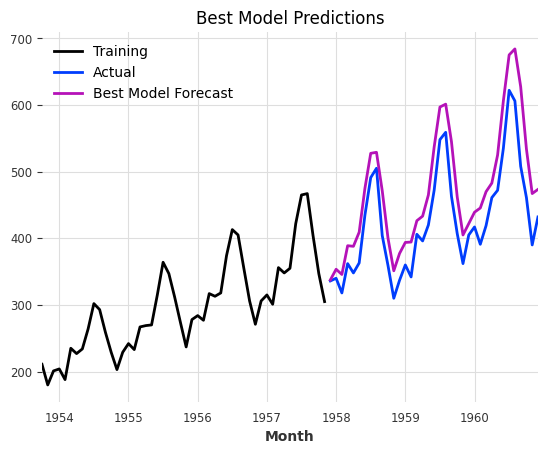

In [40]:
if runs:
    best_run = runs[0]
    best_model_uri = f"runs:/{best_run.info.run_id}/model"

    print(f"Loading best model from run: {best_run.data.tags.get('mlflow.runName')}")
    print(f"Model URI: {best_model_uri}")

    best_model = load_model(best_model_uri)
    # series param required for loaded models, since we save with clean=True
    best_predictions = best_model.predict(n=len(val), series=train)

    train[-50:].plot(label="Training")
    val.plot(label="Actual")
    best_predictions.plot(label="Best Model Forecast")
    plt.legend()
    plt.title("Best Model Predictions")
    plt.show()

## Model Registry

After comparing runs in the UI you can promote your best model to the **MLflow Model Registry** for versioning and lifecycle management (Staging → Production → Archived).

```python
# Register a model from a run
result = mlflow.register_model(
    model_uri=f"runs:/{best_run.info.run_id}/model",
    name="darts-air-passengers",
)
print(f"Registered version: {result.version}")
```

The registry is accessible in the MLflow UI under the **Models** tab, where you can add descriptions, set aliases, and compare versions side-by-side.

> 📸 **Try it:** After running the cells above, open the Models tab in the UI and register one of the runs.
>
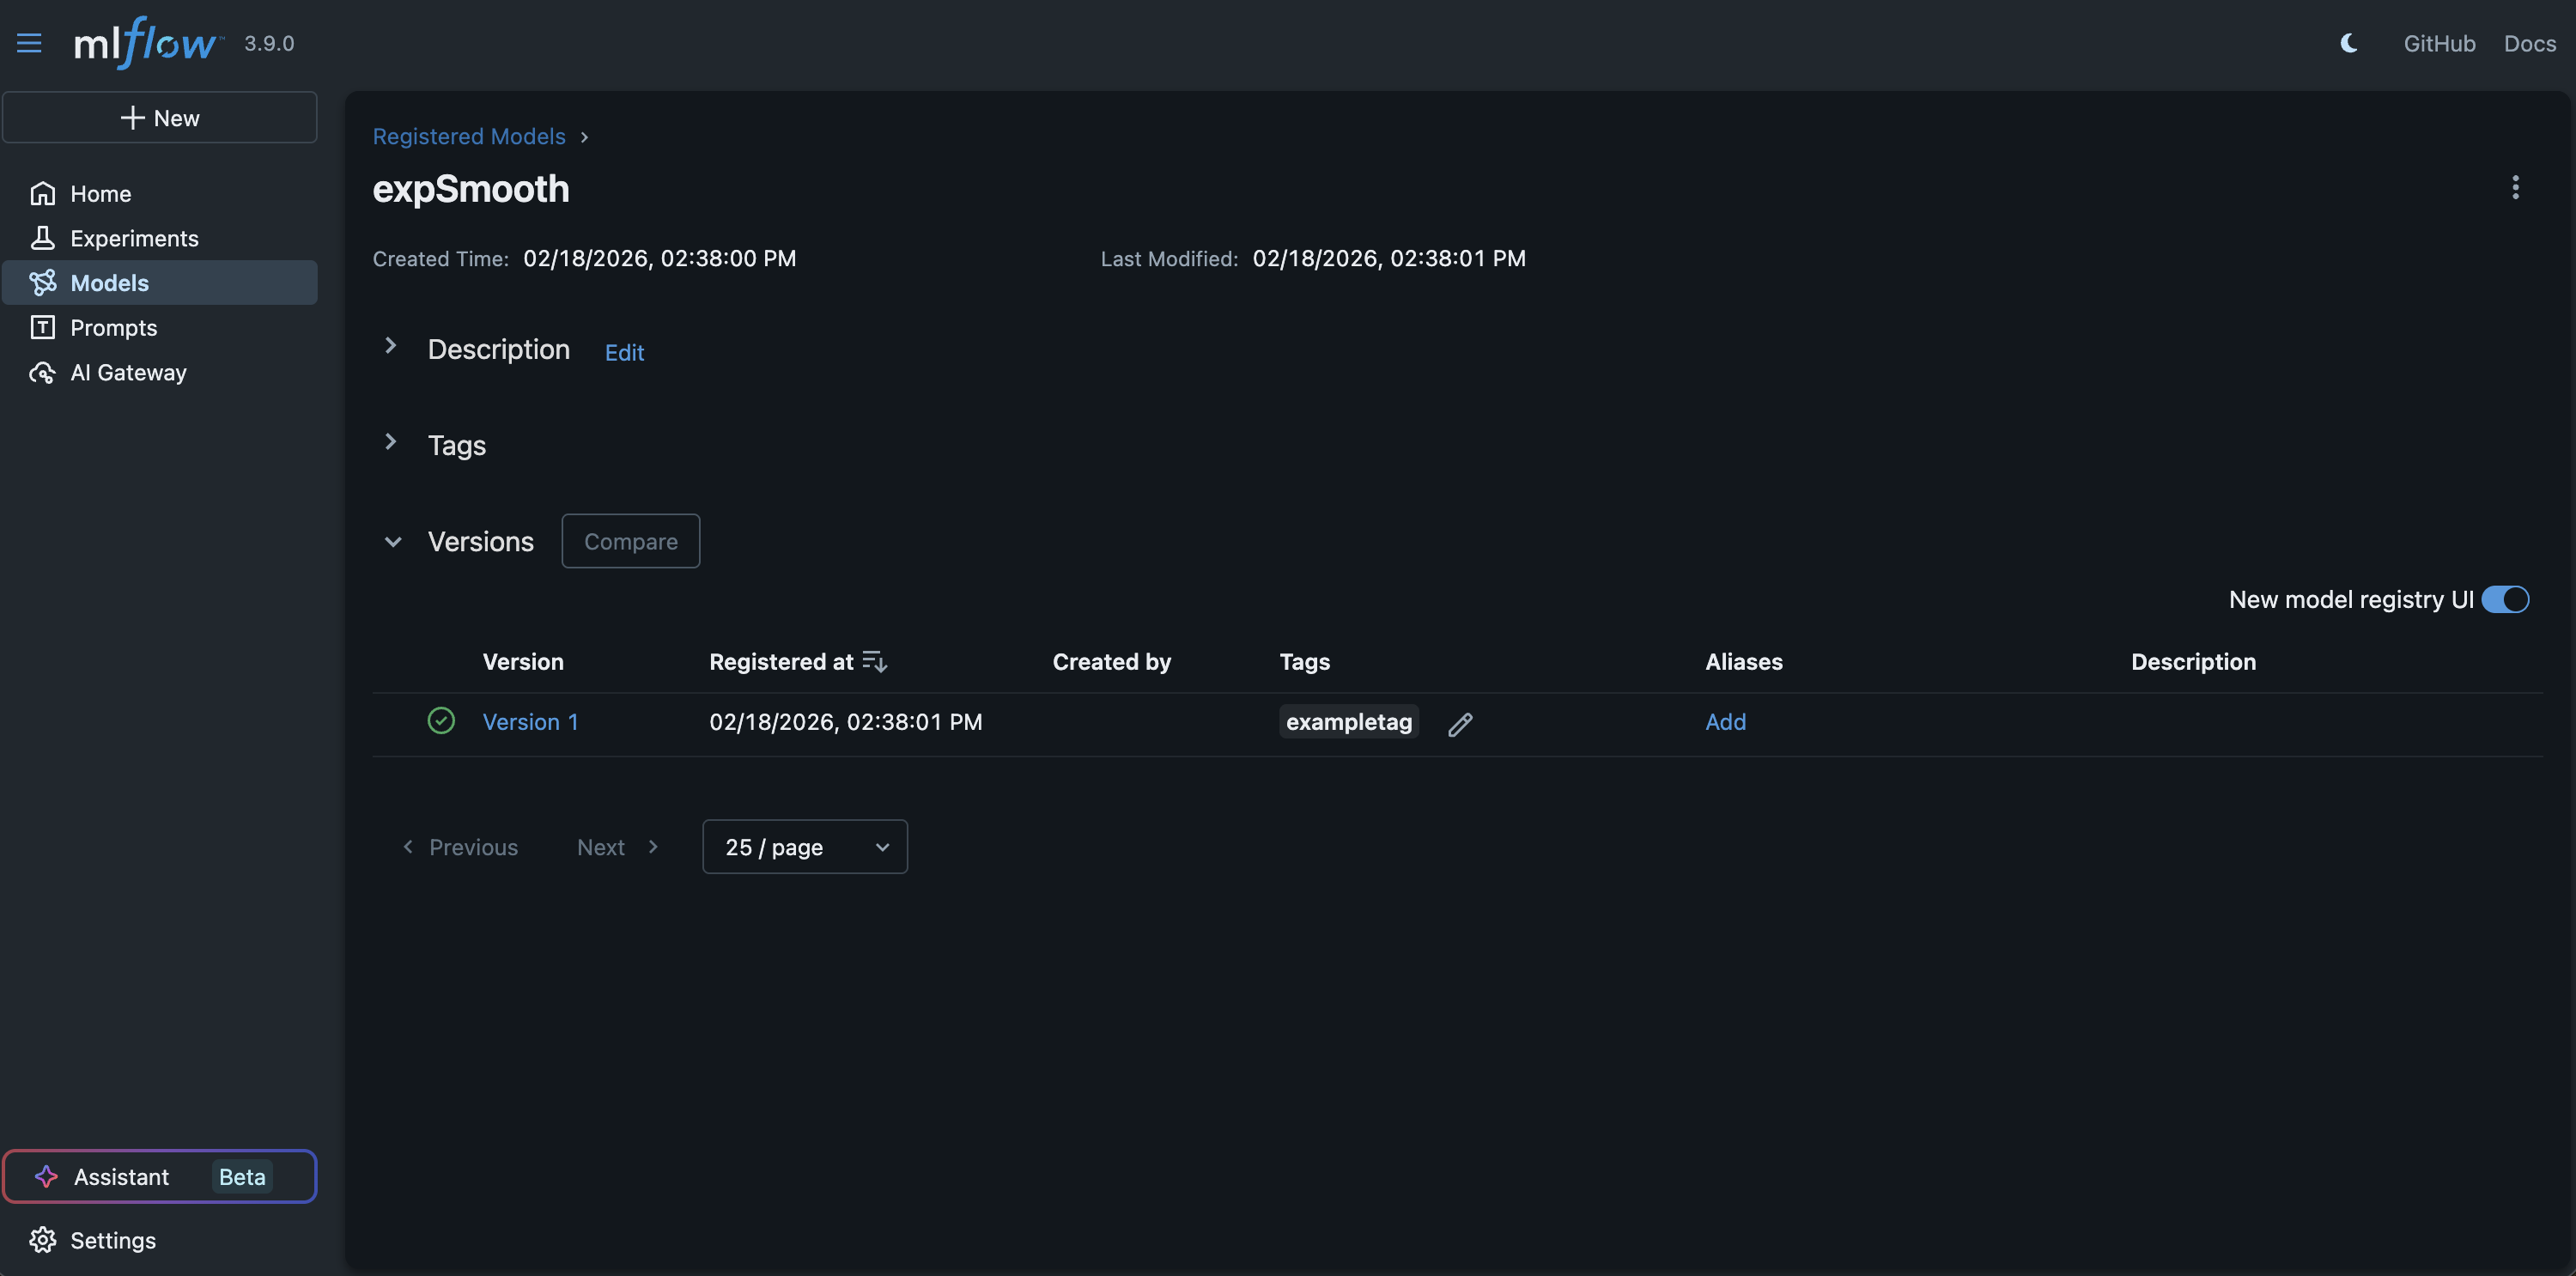

## Important Note: Custom Flavor

Since Darts uses a custom MLflow flavor on its' side it's important to import the methods accordingly.

**Always use:**
```python
from darts.utils.mlflow import load_model
model = load_model(model_uri)
```

**Instead of:**
```python
import mlflow
model = mlflow.pyfunc.load_model(model_uri)  # Will fail!
```

This custom flavor is necessary to properly handle:
- TimeSeries objects
- Darts-specific model parameters
- Covariate handling (past, future, static)
- PyTorch model state preservation

## Cleanup

In [ ]:
# Uncomment to cleanup
# import shutil
# shutil.rmtree(tmpdir)
# print(f"Cleaned up temporary directory: {tmpdir}")

print(f"To cleanup manually, delete: {tmpdir}")

# Final Remarks

Currently none of the model serving capabilities are implemented for Darts. While an API was provided (`input_example` and `signature` parameters for the `.log_model` and `.load_model`) to keep in line with MLflow API conventions, they are currently widely unsupported.